In [1]:
import awkward as ak
import matplotlib.pyplot as plt
import os, sys
import subprocess
import json
import uproot
from coffea.nanoevents import NanoEventsFactory, ScoutingNanoAODSchema
from coffea.lookup_tools.lookup_base import lookup_base
import numpy as np
from coffea import processor, util
from hist import Hist
import hist
from coffea.analysis_tools import Weights, PackedSelection
from collections import defaultdict
import mplhep
plt.style.use(mplhep.style.CMS)

In [102]:
class Processor(processor.ProcessorABC):
    def __init__(self, jet_arbitration='pt', tagger="v1", systematics=False):
        self._jet_arbitration = jet_arbitration
        self._tagger = tagger
        self._wp_btag = 0.2
        self._tightMatch = False
        self._systematics = systematics
        
    @property
    def accumulator(self):
        return {
            "sumw": defaultdict(float),
            "cutflow": (
                            Hist.new.StrCategory(
                                [], name="dataset", label="Dataset", growth=True
                            ).StrCategory(
                                [], name="region", label="Region", growth=True
                            ).StrCategory(
                                [], name="systematic", label="Systematic", growth=True
                            ).IntCategory(
                                [], name="genflavour", label="Genflavour", growth=True
                            ).Reg(
                                50, 100, 700, name="pt", label=r"Leading jet $p_T$"
                            ).Reg(
                                50, 0, 150, name="msoftdrop", label=r"Leading jet mass"
                            ).Reg(
                                50, 0, 1, name="pn_Hbb", label=r"H(bb) vs QCD score"
                            ).IntCategory(
                                [], name="cut", label="Cut Idx", growth=True
                            ).Weight()
                        ),
        }
           
        
    def process(self, events):
        return self.process_shift(events, None)
    
    def process_shift(self, events, shift_name):
        
        output = self.accumulator
        
        dataset = events.metadata['dataset']
        
        isRealData = not hasattr(events, "genWeight")
        isQCDMC = 'QCD' in dataset
        
        selection = PackedSelection()
        weights = Weights(len(events), storeIndividual=True)
        
        if shift_name is None and not isRealData:
            output['sumw'][dataset] += ak.sum(events.genWeight)
            
        if len(events) == 0:
            return output
        
        fatjets = events.ScoutingFatJet
        fatjets['qcdrho'] = 2 * np.log(fatjets.msoftdrop / fatjets.pt)
        fatjets["pn_Hbb"] = ak.where(
            (fatjets.particleNet_prob_Hbb + fatjets.particleNet_prob_QCD) == 0, 
            0, 
            (fatjets.particleNet_prob_Hbb / (fatjets.particleNet_prob_Hbb + fatjets.particleNet_prob_QCD))
        )
        
        jets = events.ScoutingJet
        jets["pn_b"] = ak.where(
            (jets.particleNet_prob_b + jets.particleNet_prob_g) == 0, 
            0, 
            (jets.particleNet_prob_b / (jets.particleNet_prob_b + jets.particleNet_prob_g))
        )
        
        candidatejet = fatjets[
            (fatjets.pt > 200)
            & (abs(fatjets.eta) < 2.5)
        ]
        
        candidatejet = candidatejet[:, :2]
        if self._jet_arbitration == 'pt':
            candidatejet = ak.firsts(candidatejet)
        else:
            raise RuntimeError("Unknown candidate jet arbitration")
            
        if self._tagger == 'v1':
            bvq = candidatejet.pn_Hbb
        else:
            raise RuntimeError("Unknown jet tag version")
            
        selection.add("trigger", events.L1["SingleJet180"])
            
        selection.add('minjetkin',
            (candidatejet.pt >= 350)
            & (candidatejet.pt < 1200)
            & (candidatejet.qcdrho < -1.7)
            & (candidatejet.qcdrho > -6.0)
            & (abs(candidatejet.eta) < 2.5)
        )
        
        selection.add('jetid', 
            (candidatejet.neHEF < 0.9)
            & (candidatejet.neEmEF < 0.9)
            & (candidatejet.muEmEF < 0.8)
            & (candidatejet.chHEF > 0.01)
            & (candidatejet.nCh > 0)
            & (candidatejet.chEmEF < 0.8)
        )
        
        jets = jets[
            (jets.pt > 30.)
            & (abs(jets.eta) < 5.0)
        ]
        
        jets = jets[:, :4]
        dphi = abs(jets.delta_phi(candidatejet))
        selection.add('ak4btagOppHem', ak.max(jets[dphi > np.pi / 2].pn_b, axis=1, mask_identity=False) < self._wp_btag) 

        met = events.ScoutingMET
        selection.add('met', met.pt < 140.)
        
        goodmuon = (
            (events.ScoutingMuon.pt > 55)
            & (abs(events.ScoutingMuon.eta) < 2.4)
            & (abs(events.ScoutingMuon.trk_dxy) < 0.2)
            #& (abs(events.ScoutingMuon.trk_dz) < 0.5)
            #& (events.ScoutingMuon["type"] == 2)
            & (events.ScoutingMuon.normchi2 < 10)
            & (events.ScoutingMuon.nValidRecoMuonHits > 0)
            & (events.ScoutingMuon.nRecoMuonMatchedStations > 1)
            & (events.ScoutingMuon.nValidPixelHits > 0)
            & (events.ScoutingMuon.nTrackerLayersWithMeasurement > 5)            
        )
        
        nmuons = ak.sum(goodmuon, axis=1)
        leadingmuon = ak.firsts(events.ScoutingMuon[goodmuon])

        goodelectron = (
            (events.ScoutingElectron.pt > 10)
            & (abs(events.ScoutingElectron.eta) < 2.5)
        )
        nelectrons = ak.sum(goodelectron, axis=1)
        
        selection.add('noleptons', (nmuons == 0) & (nelectrons == 0))
        
        if isRealData :
            genflavour = ak.zeros_like(candidatejet.pt)
        else:
            weights.add('genweight', events.genWeight)

            bosons = self.getBosons(events.GenPart)
            matchedBoson = candidatejet.nearest(bosons, axis=None, threshold=0.8)
            if self._tightMatch:
                match_mask = ((candidatejet.pt - matchedBoson.pt)/matchedBoson.pt < 0.5) & ((candidatejet.msoftdrop - matchedBoson.mass)/matchedBoson.mass < 0.3)
                selmatchedBoson = ak.mask(matchedBoson, match_mask)
                genflavour = self.bosonFlavour(selmatchedBoson)
            else:
                genflavour = self.bosonFlavour(matchedBoson)
            genBosonPt = ak.fill_none(ak.firsts(bosons.pt), 0)
            
        msoftdrop_matched = candidatejet.msoftdrop * (genflavour > 0) + candidatejet.msoftdrop * (genflavour == 0)
            
        regions = {
            'signal': ['trigger','minjetkin','jetid','ak4btagOppHem','met','noleptons'],
        }
        
        def normalize(val, cut):
            if cut is None:
                ar = ak.to_numpy(ak.fill_none(val, np.nan))
                return ar
            else:
                ar = ak.to_numpy(ak.fill_none(val[cut], np.nan))
                return ar
            
        if shift_name is None:
            systematics = [None] + list(weights.variations)
        else:
            systematics = [shift_name]
            
        for region, cuts in regions.items():
            if region == "noselection":
                continue
            allcuts = set([])
            cut = selection.all(*allcuts)
            
            output['cutflow'].fill(
                dataset=dataset,
                region=region,
                systematic="snominal",
                genflavour=normalize(genflavour, cut),
                pt=normalize(candidatejet.pt, cut),
                msoftdrop=normalize(msoftdrop_matched, cut),
                pn_Hbb=normalize(bvq, cut),
                weight=weights.weight(),
                cut=0,
            )
            
            for i, cut in enumerate(cuts):
                allcuts.add(cut)
                cut = selection.all(*allcuts)
                
                output['cutflow'].fill(
                    dataset=dataset,
                    region=region,
                    systematic="snominal",
                    genflavour=normalize(genflavour, cut),
                    pt=normalize(candidatejet.pt, cut),
                    msoftdrop=normalize(msoftdrop_matched, cut),
                    pn_Hbb=normalize(bvq, cut),
                    weight=weights.weight()[cut],
                    cut=i+1,
            )
            
#         def fill(region, systematic):
#             selections = regions[region]
#             cut = selection.all(*selections)
#             sname = 'nominal' if systematic is None else systematic
#             if systematic in weights.variations:
#                 weight = weights.weight(modifier=systematic)[cut]
#             else:
#                 weight = weights.weight()[cut]

#             output['templates'].fill(
#                 dataset=dataset,
#                 region=region,
#                 systematic=sname,
#                 genflavour=normalize(genflavour, cut),
#                 pt=normalize(candidatejet.pt, cut),
#                 msoftdrop=normalize(msoftdrop_matched, cut),
#                 pn_Hbb=normalize(bvq, cut),
#                 weight=weight,
#             )
            
#         for region in regions:
#             for systematic in systematics:
#                 if isRealData and systematic is not None:
#                     continue
#                 fill(region, systematic)
                
        if shift_name is None:
            output["weightStats"] = weights.weightStatistics
        
        return output
    
    def getBosons(self, genparticles):
        absid = abs(genparticles.pdgId)
        return genparticles[
            (absid >= 22) # no gluons
            & (absid <= 25)
            & genparticles.hasFlags(['fromHardProcess', 'isLastCopy'])
        ]

    def bosonFlavour(self, bosons):
        childid = abs(bosons.children.pdgId)
        genflavour = ak.any(childid == 5, axis=-1) * 5 + ak.any(childid == 4, axis=-1) * 4 + ak.all(childid < 4, axis=-1) * 1        
        return ak.fill_none(genflavour, 0)
    
    def postprocess(self, accumulator):
        return accumulator

In [42]:
fileset_mc = {
    "TTtoLNu2Q" : [
        "root://eosuser.cern.ch//eos/user/a/adlintul/TTtoLNu2Q_TuneCP5_13p6TeV_powheg-pythia8/Run3Summer22/230131_071621/0000/nanoaod_1.root"
    ],
}

fileset_data = {
    "Run2022D" : [
        "root://eosuser.cern.ch//eos/user/a/adlintul/ScoutingPFRun3/Run2022D/230206_163934/0000/scoutingnano_1.root"
    ],
}

p = Processor()

futures_run = processor.Runner(
    executor = processor.FuturesExecutor(compression=None, workers=1),
    schema = ScoutingNanoAODSchema,
    #maxchunks = 10,
)

data = True

out = futures_run(
    fileset_data if data else fileset_mc,
    treename="Events",
    processor_instance=p
)

name = "Run2022D" if data else "TTtoLNu2Q"

util.save(out, f"outfiles/zbb_{name}.coffea")

Output()

/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


In [136]:
data["cutflow"]

Hist(
  StrCategory(['Run2022D'], growth=True, name='dataset', label='Dataset'),
  StrCategory(['signal'], growth=True, name='region', label='Region'),
  StrCategory(['snominal'], growth=True, name='systematic', label='Systematic'),
  IntCategory([-2.14748e+09, 0], growth=True, name='genflavour', label='Genflavour'),
  Regular(50, 100, 700, name='pt', label='Leading jet $p_T$'),
  Regular(50, 0, 150, name='msoftdrop', label='Leading jet mass'),
  Regular(50, 0, 1, name='pn_Hbb', label='H(bb) vs QCD score'),
  IntCategory([0, 1, 2], growth=True, name='cut', label='Cut Idx'),
  storage=Weight()) # Sum: WeightedSum(value=10046, variance=10046) (WeightedSum(value=340701, variance=340701) with flow)

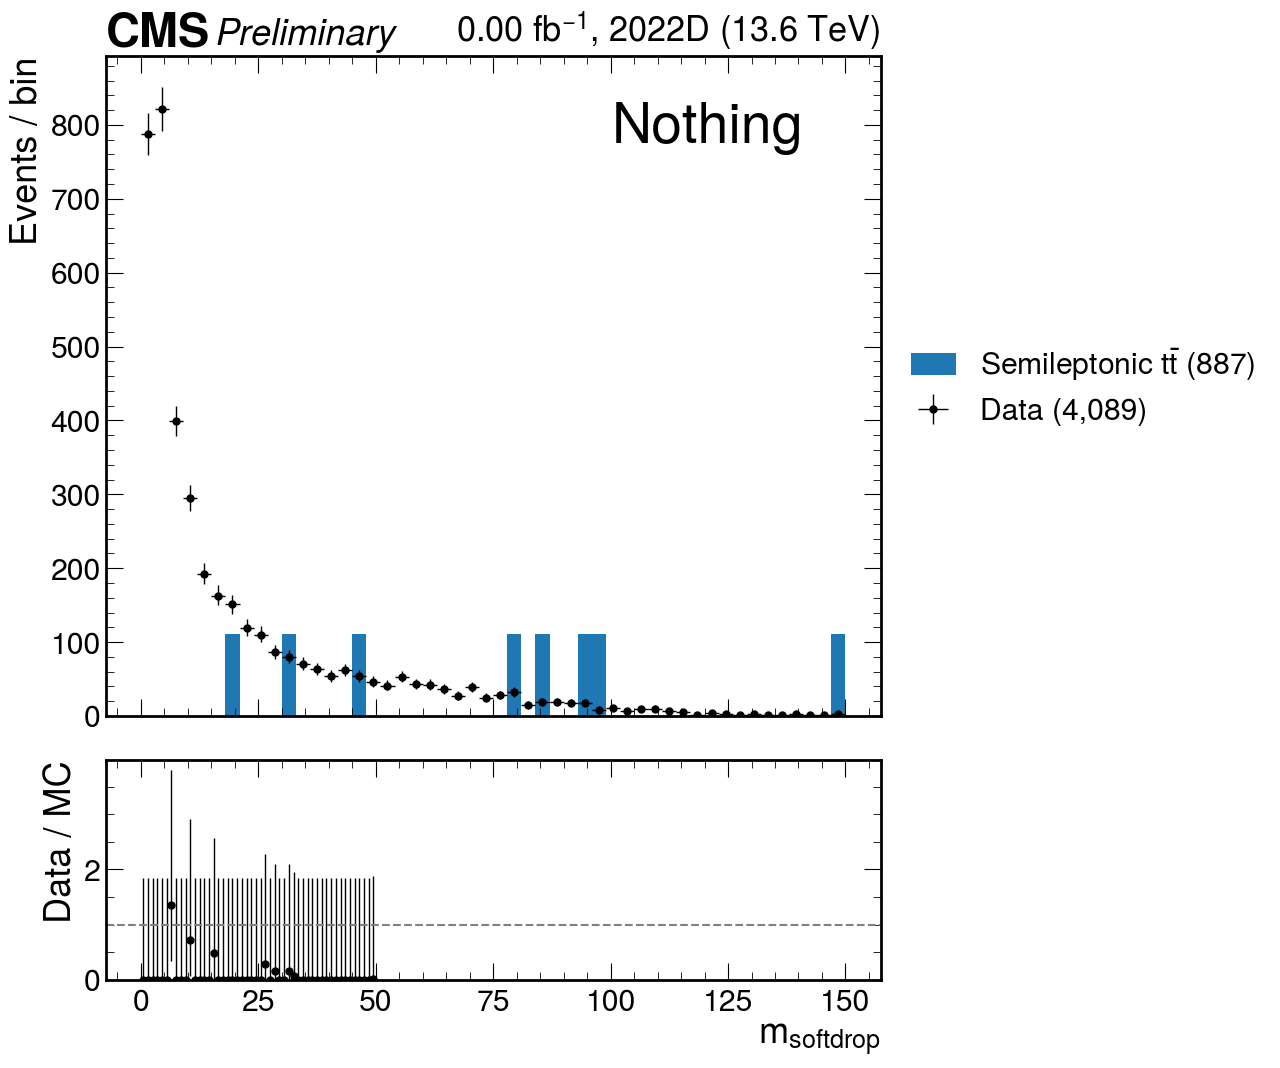

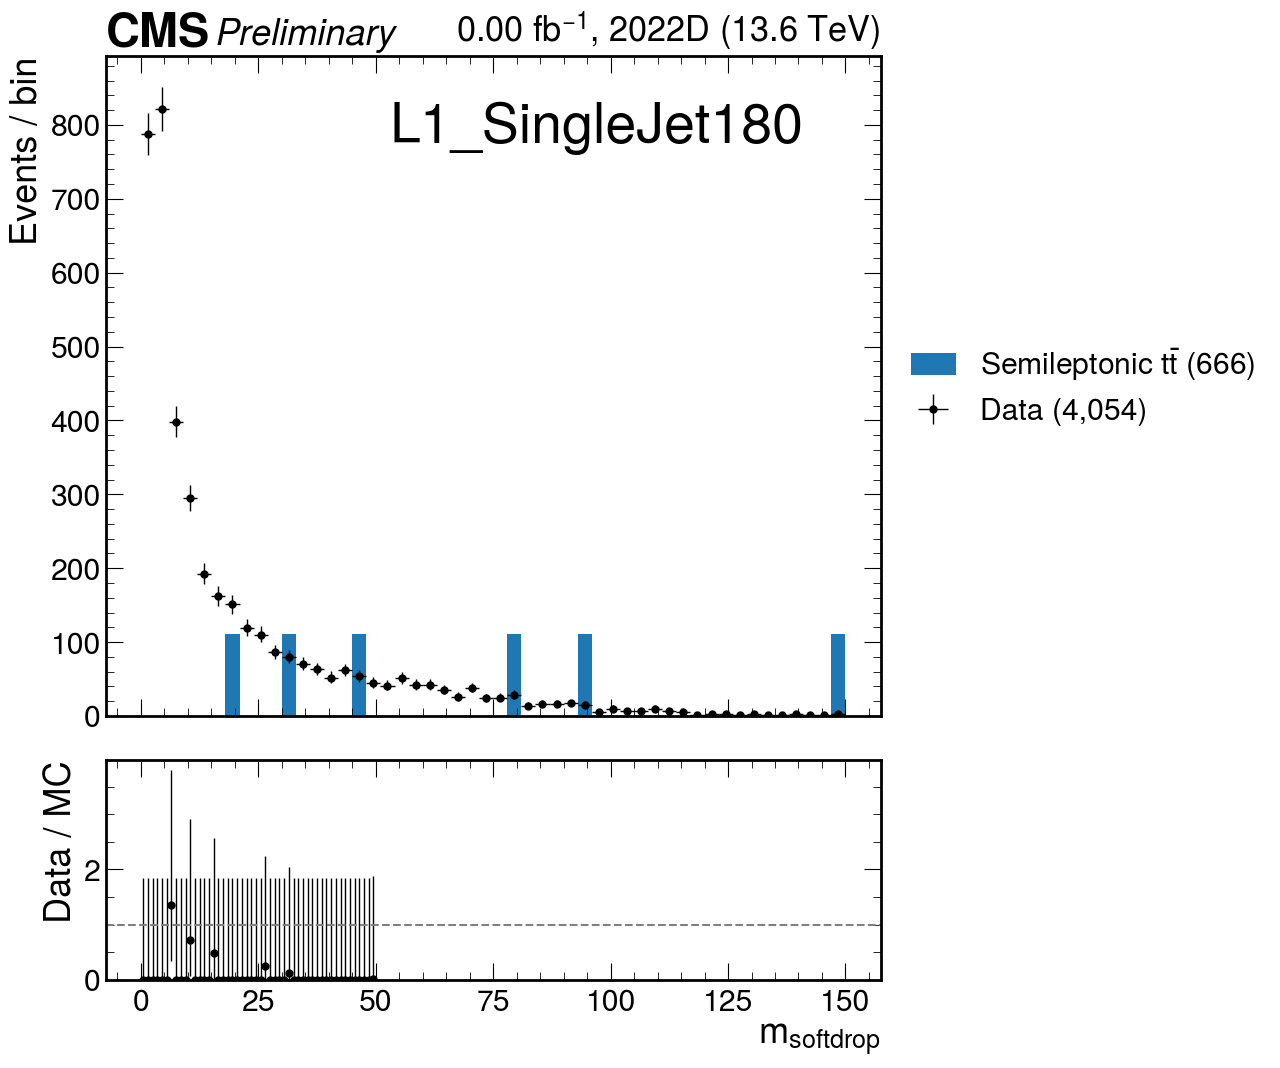

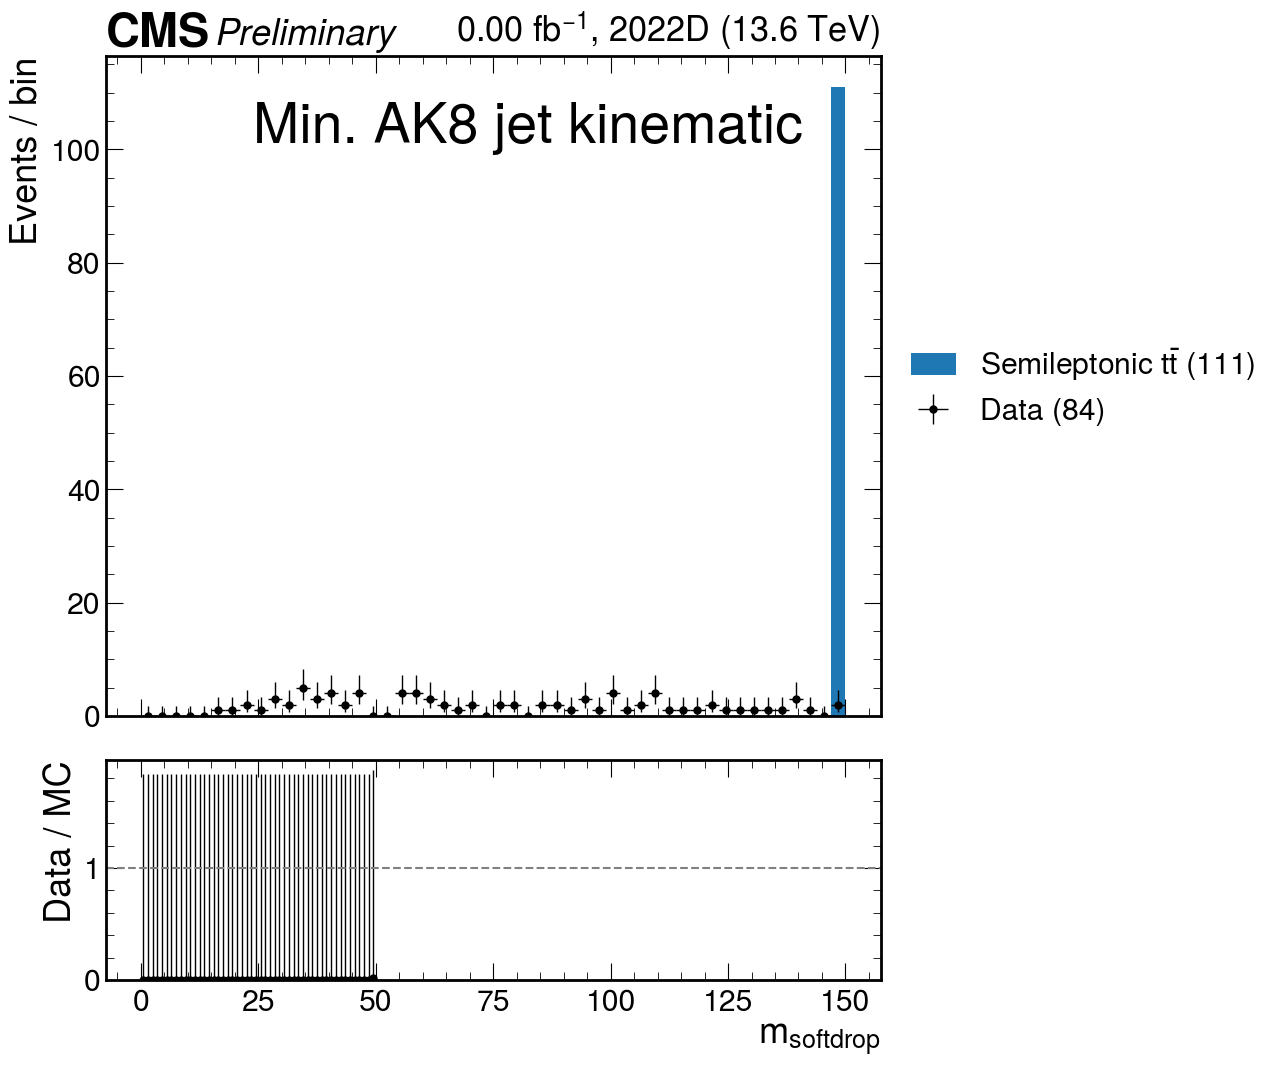

In [137]:
data = util.load("outfiles/zbb_Run2022D.coffea")
mc = util.load("outfiles/zbb_TTtoLNu2Q.coffea")

lumis = {
    "2022d" : 0.1,
}
xs = {
    "TTtoLNu2Q" : 762.136984,
}
era = "2022d"

cuts = [
    'Nothing',
    'L1_SingleJet180',
    'Min. AK8 jet kinematic',
    'Jet ID',
    'Opp. hem. AK4 b-jet',
    'Lepton veto',
    'MET < 140',
]

scale_lumi = {k: xs[k] * 1000 * lumis[era] / w for k, w in mc['sumw'].items()}
    
h_data =  data["cutflow"][{
    "dataset" : sum,
    "region" : sum,
    "systematic" : sum,
    "genflavour" : sum,
    "pn_Hbb" : slice(hist.underflow+1, hist.overflow-1, sum), 
    "pt" : slice(hist.underflow, hist.overflow, sum),
}]
h_mc = mc["cutflow"][{
    "region" : sum,
    "systematic" : sum,
    "genflavour" : sum,
    "pn_Hbb" : slice(hist.underflow+1, hist.overflow-1, sum), 
    "pt" : slice(hist.underflow, hist.overflow, sum),
}]

for i, name in enumerate(h_mc.axes["dataset"]):
    h_mc.view(flow=True)[i] *= scale_lumi[name]
    
for i in [0, 1, 2]: #h_mc.axes["cut"]:

    fig, (ax, rax) = plt.subplots(
        2, 1, figsize=(10, 12), gridspec_kw={"height_ratios": (3, 1)}, sharex=True
    )
    fig.subplots_adjust(hspace=0.1)
    ax.set_ylabel("Events / bin")
    rax.set_ylabel("Data / MC")
    rax.set_xlabel(r"m$_{softdrop}$")
    ax.set_xlabel(" ")
    
    hh_mc = h_mc[{"dataset" : sum, "cut" : hist.loc(i)}]
    
    mplhep.histplot(
        hh_mc,
        ax=ax, 
        histtype="fill",
        label=r"Semileptonic $t\bar{t}$" + f" ({hh_mc.sum().value:,.0f})"
    )

    hh_data = h_data[{"cut" : hist.loc(i)}]
    
    mplhep.histplot(
        hh_data, 
        ax=ax, 
        histtype="errorbar",
        xerr=True,
        c="black",
        label=f"Data ({hh_data.sum().value:,.0f})"
    )
    
    ratio = [data/mc if mc != 0 else 0 for (data, mc) in zip(hh_data.values(), hh_mc.values())]
    
    mplhep.histplot(
        ratio, 
        ax=rax, 
        histtype="errorbar",
        xerr=True,
        c="black"
    )
    
    rax.axhline(1, color='gray',ls='--')
    
    plt.text(0.9, 0.85, f"{cuts[i]}",
                fontsize=40,
                horizontalalignment='right',
                verticalalignment='bottom',
                transform=ax.transAxes
               )

    mplhep.cms.label(
            ax=ax, 
            data=True, 
            label="Preliminary",
            year="2022D",
            lumi=f"{lumis[era]/1000:.2f}",
            com=13.6,
        )
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

/opt/conda/lib/python3.8/site-packages/mplhep/error_estimation.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/mplhep/error_estimation.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/mplhep/error_estimation.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/mplhep/error_estimation.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(


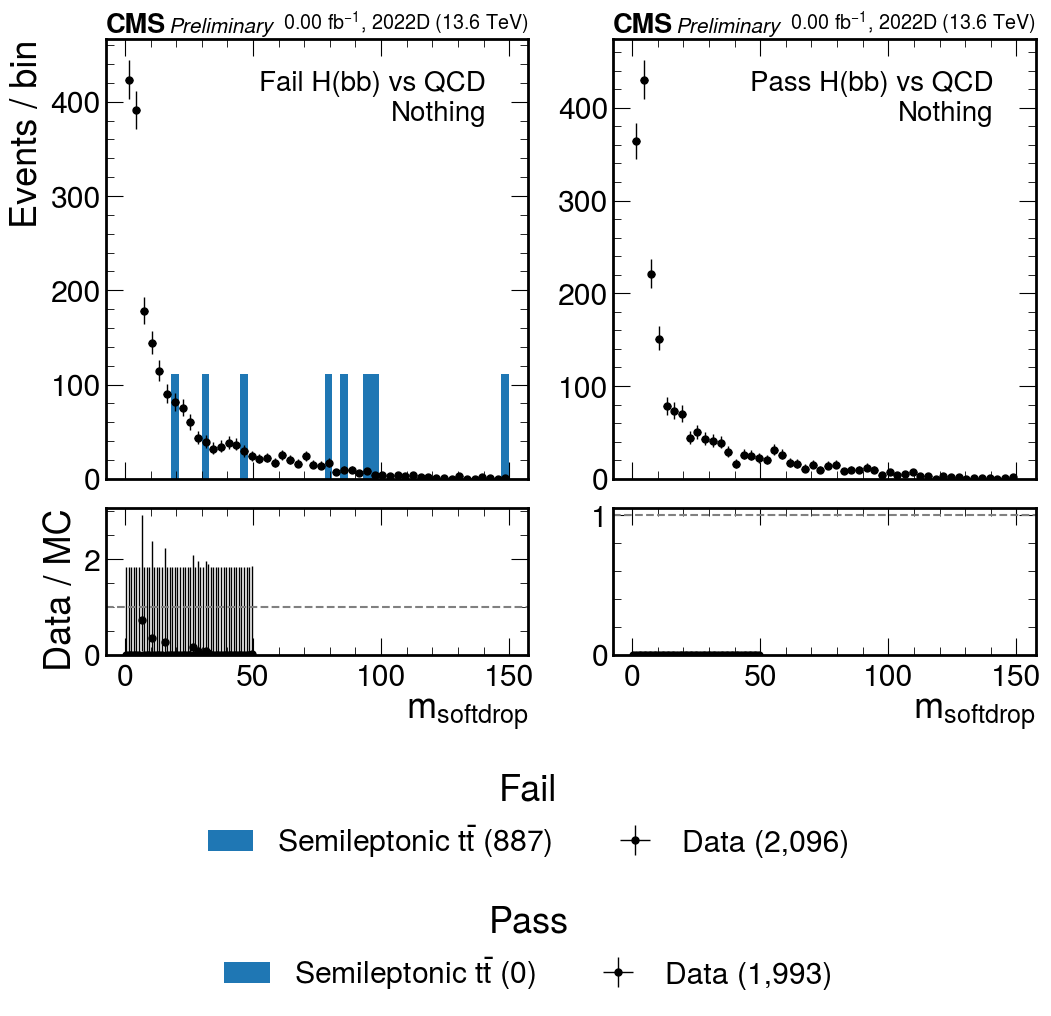

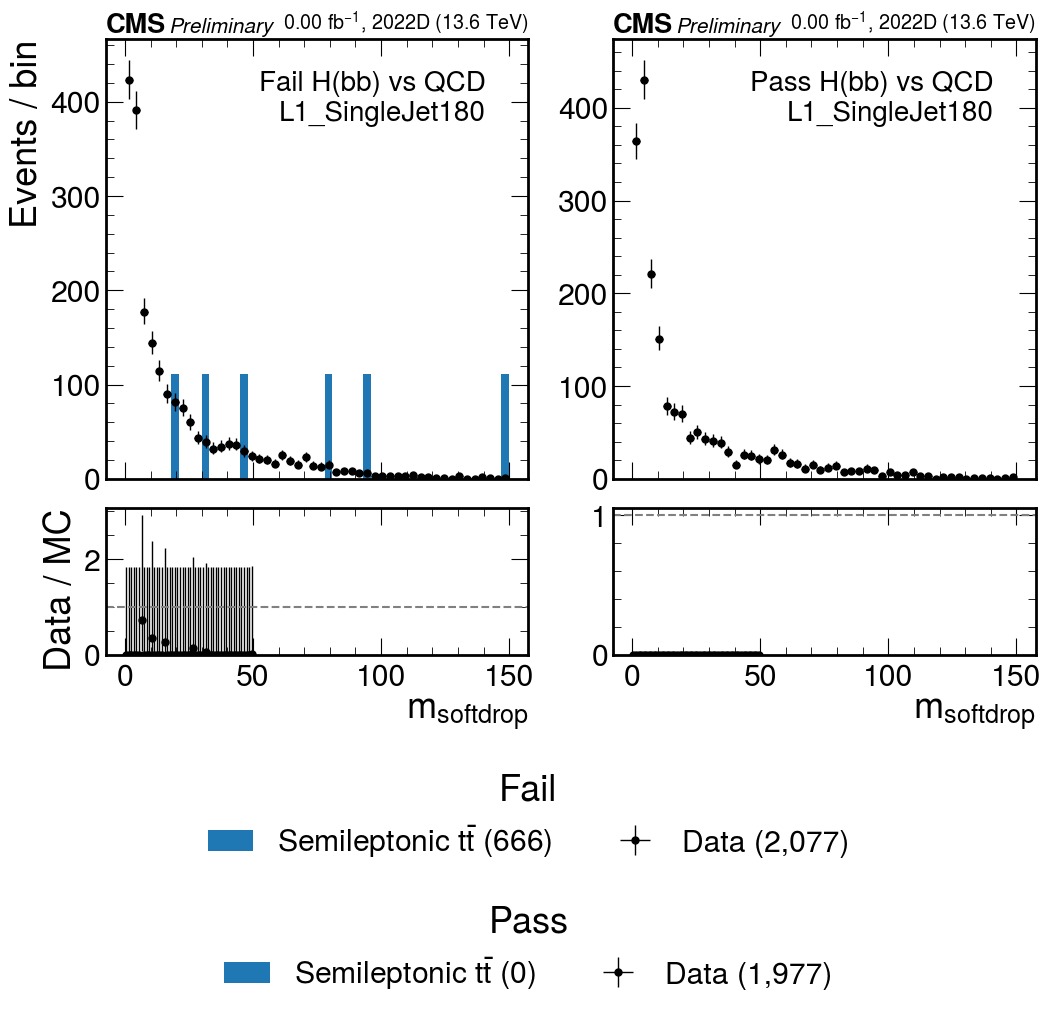

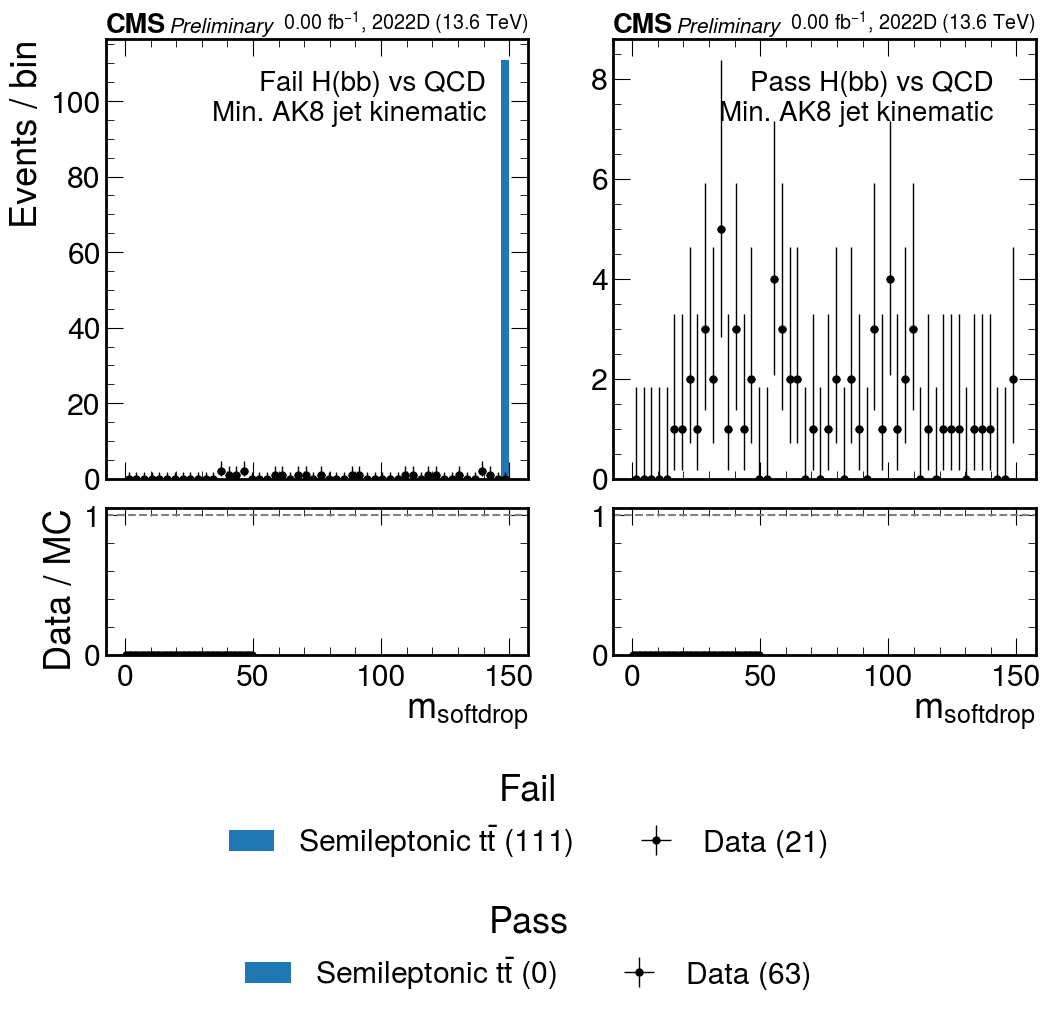

In [152]:
data = util.load("outfiles/zbb_Run2022D.coffea")
mc = util.load("outfiles/zbb_TTtoLNu2Q.coffea")

lumis = {
    "2022d" : 0.1,
}
xs = {
    "TTtoLNu2Q" : 762.136984,
}
era = "2022d"

cuts = [
    'Nothing',
    'L1_SingleJet180',
    'Min. AK8 jet kinematic',
    'Jet ID',
    'Opp. hem. AK4 b-jet',
    'Lepton veto',
    'MET < 140',
]

region = {
    0 : "Fail H(bb) vs QCD",
    1 : "Pass H(bb) vs QCD",
}

scale_lumi = {k: xs[k] * 1000 * lumis[era] / w for k, w in mc['sumw'].items()}
    
h_data =  data["cutflow"][{
    "dataset" : sum,
    "region" : sum,
    "systematic" : sum,
    "genflavour" : sum,
    "pt" : slice(hist.underflow, hist.overflow, sum),
}]
h_mc = mc["cutflow"][{
    "region" : sum,
    "systematic" : sum,
    "genflavour" : sum,
    "pt" : slice(hist.underflow, hist.overflow, sum),
}]

for i, name in enumerate(h_mc.axes["dataset"]):
    h_mc.view(flow=True)[i] *= scale_lumi[name]
    
for i in h_data.axes["cut"]:

    fig, (ax, rax) = plt.subplots(
        2, 2, figsize=(12, 8), gridspec_kw={"height_ratios": (3, 1)}, sharex=True
    )
    
    for j, _ in enumerate(["fail", "pass"]):
    
        fig.subplots_adjust(hspace=0.1)
        ax[j].set_ylabel("Events / bin" if j == 0 else " ")
        rax[j].set_ylabel("Data / MC" if j == 0 else " ")
        rax[j].set_xlabel(r"m$_{softdrop}$")
        ax[j].set_xlabel(" ")
    
        sli = slice(hist.underflow+1, 0.4j, sum) if j == 0 else slice(0.4j, hist.overflow-1, sum)
        hh_mc = h_mc[{"dataset" : sum, "cut" : hist.loc(i), "pn_Hbb" : sli}]

        mplhep.histplot(
            hh_mc,
            ax=ax[j], 
            histtype="fill",
            label=r"Semileptonic $t\bar{t}$" + f" ({hh_mc.sum().value:,.0f})"
        )

        hh_data = h_data[{"cut" : hist.loc(i), "pn_Hbb" : sli}]

        mplhep.histplot(
            hh_data, 
            ax=ax[j], 
            histtype="errorbar",
            xerr=True,
            c="black",
            label=f"Data ({hh_data.sum().value:,.0f})"
        )

        ratio = [data/mc if mc != 0 else 0 for (data, mc) in zip(hh_data.values(), hh_mc.values())]

        mplhep.histplot(
            ratio, 
            ax=rax[j], 
            histtype="errorbar",
            xerr=True,
            c="black"
        )

        rax[j].axhline(1, color='gray',ls='--')

        plt.text(0.9, 0.8, f"{region[j]}\n{cuts[i]}",
                    fontsize=20,
                    horizontalalignment='right',
                    verticalalignment='bottom',
                    transform=ax[j].transAxes
                   )

        mplhep.cms.label(
                ax=ax[j], 
                data=True, 
                label="Preliminary",
                year="2022D",
                lumi=f"{lumis[era]/1000:.2f}",
                com=13.6,
                fontsize=15,
            )
    
    ax[0].legend(loc='upper center', title="Fail", bbox_to_anchor=(1, -0.6), ncol=2)
    ax[1].legend(loc='upper center', title="Pass", bbox_to_anchor=(-0.2, -0.9), ncol=2)